Simple example of single-window 4Dvar assimilation on the quasi-geostrophic system of equations.
This notebook is meant to be run with a GPU, preferably one with a high amount of memory such as A100-80GB.

We rely on the pytorch implementation of the equations by Louis Thiry: https://github.com/louity/qgm_pytorch

In [ ]:
import os
import torch
from matplotlib import pyplot as plt
from time import time
from tensordict import TensorDict
from QG.QGM import *
os.chdir('..')
from da_tools.variational.hard_constraint_4dvar import hc4dvar_single_window
from da_tools.variational.weak_constraint_4dvar import wc4dvar_single_window
from da_tools.system.state import State
from da_tools.observation.operators import random_sparse_noisy_obs
from da_tools.util.initialization import naive_initialization
from da_tools.probability.distributions import DiagonalGaussian
from da_tools.util.visualization import show_1dseqimg

# Data generation

In [ ]:
torch.backends.cudnn.deterministic = True

param = {
    # 'nx': 769, # HR
    # 'ny': 961, # HR
    'nx': 97, # LR
    'ny': 121, # LR
    'Lx': 3840.0e3, # Length in the x direction (m)
    'Ly': 4800.0e3, # Length in the y direction (m)
    'nl': 3, # number of layers
    'heights': [350., 750., 2900.], # heights between layers (m)
    'reduced_gravities': [0.025, 0.0125], # reduced gravity numbers (m/s^2)
    'f0': 9.375e-5, # coriolis (s^-1)
    'a_2': 0., # laplacian diffusion coef (m^2/s)
    # 'a_4': 2.0e9, # HR
    'a_4': 5.0e11, # LR
    'beta': 1.754e-11, # coriolis gradient (m^-1 s^-1)
    'delta_ek': 2.0, # eckman height (m)
    # 'dt': 600., # HR (10 minutes)
    'dt': 1200., # LR (20 minutes)
    'bcco': 0.2, # boundary condition coef. (non-dim.)
    'tau0': 2.0e-5, # wind stress magnitude m/s^2
    'n_ens': 0, # 0 for no ensemble,
    'device': 'cuda', # torch only, 'cuda' or 'cpu'
    'p_prime': ''
}

device = param['device']

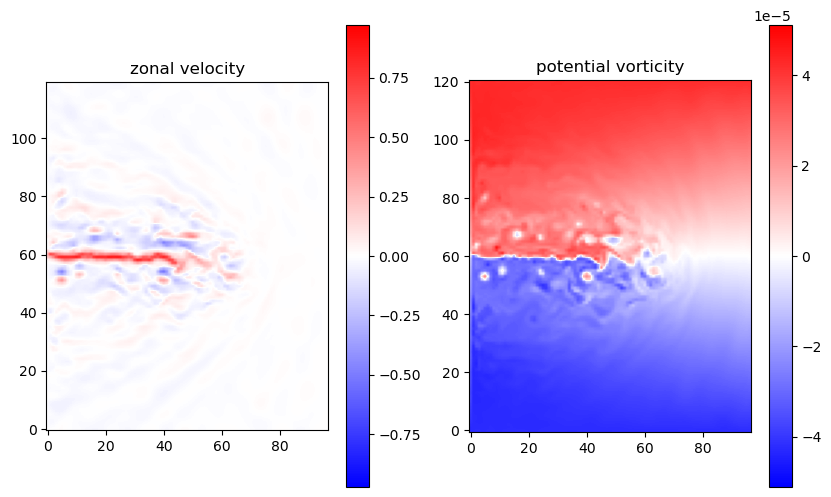

n=001000, t=0.04 yr, p: (+1.4E-02, 3.461901E-01), q: (-4.1E-10, 2.270768E-05).
n=002000, t=0.08 yr, p: (-2.2E-02, 3.431303E-01), q: (+5.9E-10, 2.268778E-05).
n=003000, t=0.11 yr, p: (+2.9E-02, 3.436991E-01), q: (+7.1E-10, 2.267402E-05).
n=004000, t=0.15 yr, p: (-1.1E-02, 3.308274E-01), q: (+9.7E-10, 2.266169E-05).
n=005000, t=0.19 yr, p: (-2.4E-02, 3.177581E-01), q: (+7.4E-10, 2.265153E-05).
n=006000, t=0.23 yr, p: (+4.2E-02, 3.196298E-01), q: (-1.9E-10, 2.264189E-05).
n=007000, t=0.27 yr, p: (+1.4E-02, 3.219384E-01), q: (+2.4E-10, 2.263479E-05).
n=008000, t=0.30 yr, p: (-2.1E-02, 3.105730E-01), q: (+1.3E-09, 2.262738E-05).
n=009000, t=0.34 yr, p: (+1.2E-03, 2.986354E-01), q: (+1.4E-09, 2.261995E-05).
n=010000, t=0.38 yr, p: (-2.4E-04, 2.935978E-01), q: (+1.0E-09, 2.261223E-05).
n=011000, t=0.42 yr, p: (+6.6E-03, 2.944948E-01), q: (+7.0E-10, 2.260417E-05).
n=012000, t=0.46 yr, p: (+1.4E-02, 2.966658E-01), q: (+4.7E-10, 2.259633E-05).
n=013000, t=0.49 yr, p: (+1.2E-02, 2.843394E-01), q:

In [ ]:
qg_multilayer = QGM(param)

if param['nx'] == 97:
    qg_multilayer.p = torch.from_numpy(np.load('notebooks/QG/p_380yrs_HRDS.npy')).to(param['device'])
qg_multilayer.compute_q_over_f0_from_p()


# time params
dt = param['dt']
t = 0

freq_plot = 1000000 # LR
# freq_plot = 50 # HR
freq_checknan = 10000
freq_log = 1000
n_years = 1.5
n_steps = int(n_years*365*24*3600 / dt)

if freq_plot > 0:
    import matplotlib.pyplot as plt
    plt.ion()
    f,a = plt.subplots(1,2, figsize=(10,6))
    u = (qg_multilayer.compute_u()[0]).cpu().numpy()
    um, uM = -1.1*np.abs(u).max(), 1.1*np.abs(u).max()
    im = a[0].imshow(u[0].T, cmap='bwr', origin='lower', vmin=um, vmax=uM, animated=True)
    a[0].set_title('zonal velocity')
    f.colorbar(im, ax=a[0])
    q = (qg_multilayer.q_over_f0*qg_multilayer.f0).cpu().numpy()
    qm, qM = -1.1*np.abs(q).max(), 1.1*np.abs(q).max()
    im = a[1].imshow(q[0].T, cmap='bwr', origin='lower', vmin=qm, vmax=qM, animated=True)
    a[1].set_title('potential vorticity')
    f.colorbar(im, ax=a[1])
    plt.pause(5)

times, outputs = [], []

time_series_p = torch.zeros(n_steps+1, *qg_multilayer.p.shape).to(qg_multilayer.p.dtype)
time_series_q_over_f0 = torch.zeros(n_steps+1, *qg_multilayer.q_over_f0.shape).to(qg_multilayer.q_over_f0.dtype)

time_series_p[0] = qg_multilayer.p.clone()
time_series_q_over_f0[0] = qg_multilayer.q_over_f0.clone()

t0 = time()
for n in range(1, n_steps+1):
    qg_multilayer.step()
    t += dt

    time_series_p[n] = qg_multilayer.p.clone()
    time_series_q_over_f0[n] = qg_multilayer.q_over_f0.clone()

    if n % freq_checknan == 0 and torch.isnan(qg_multilayer.p).any():
        raise ValueError('Stopping, NAN number in p at iteration {n}.')

    if freq_plot > 0 and n % freq_plot == 0:
        u = (qg_multilayer.compute_u()[0]).cpu().numpy()
        a[0].imshow(u[0].T, cmap='bwr', origin='lower', vmin=um, vmax=uM, animated=True)
        q = (qg_multilayer.q_over_f0*qg_multilayer.f0).cpu().numpy()
        a[1].imshow(q[0].T, cmap='bwr', origin='lower', vmin=qm, vmax=qM, animated=True)
        plt.suptitle(f't={t/(365*24*3600):.2f} years.')
        plt.pause(0.1)

    if freq_log > 0 and n % freq_log == 0:
        q, p = (qg_multilayer.f0 * qg_multilayer.q_over_f0).cpu().numpy(), qg_multilayer.p.cpu().numpy()
        print(f'{n=:06d}, t={t/(365*24*60**2):.2f} yr, ' \
              f'p: ({p.mean():+.1E}, {np.abs(p).mean():.6E}), ' \
              f'q: ({q.mean():+.1E}, {np.abs(q).mean():.6E}).')
print(f'Total computation time: {time()-t0} seconds')

Let us now visualise the pressure and vorticity fields on the 3 layers and at different time steps.

Text(0.5, 1.0, 'Time step 20000, layer 3')

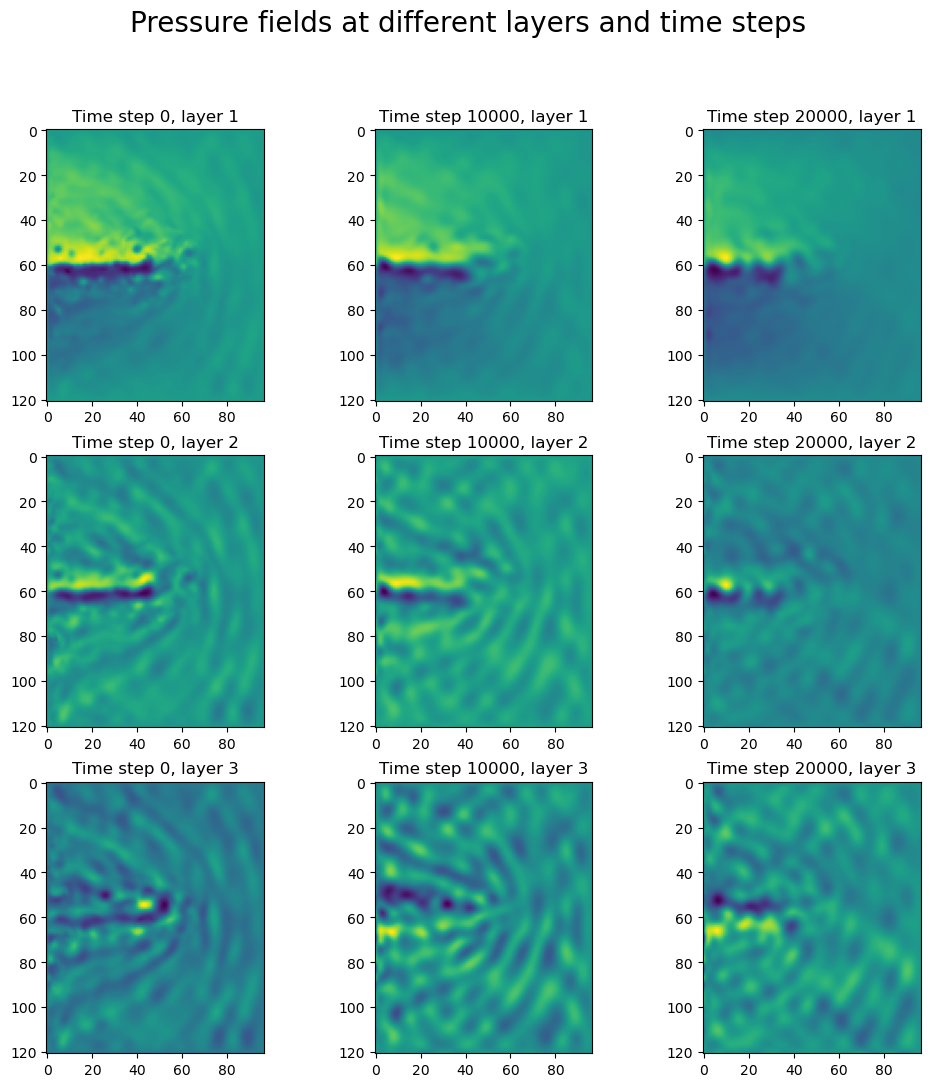

In [ ]:
vmin, vmax = torch.min(time_series_p), torch.max(time_series_p)

normalized_ts_p = (time_series_p.clone().to(torch.float16) - vmin) / (vmax - vmin)

times = [k*10000 for k in range(3)]
fig, ax = plt.subplots(3, 3, figsize=(12,12))

fig.suptitle('Pressure fields at different layers and time steps', fontsize=20)

ax[0,0].imshow(normalized_ts_p[times[0], 0].permute((1,0)))
ax[0,0].set_title(f'Time step {times[0]}, layer 1')

ax[0,1].imshow(normalized_ts_p[times[1], 0].permute((1,0)))
ax[0,1].set_title(f'Time step {times[1]}, layer 1')

ax[0,2].imshow(normalized_ts_p[times[2], 0].permute((1,0)))
ax[0,2].set_title(f'Time step {times[2]}, layer 1')

ax[1,0].imshow(normalized_ts_p[times[0], 1].permute((1,0)))
ax[1,0].set_title(f'Time step {times[0]}, layer 2')

ax[1,1].imshow(normalized_ts_p[times[1], 1].permute((1,0)))
ax[1,1].set_title(f'Time step {times[1]}, layer 2')

ax[1,2].imshow(normalized_ts_p[times[2], 1].permute((1,0)))
ax[1,2].set_title(f'Time step {times[2]}, layer 2')

ax[2,0].imshow(normalized_ts_p[times[0], 2].permute((1,0)))
ax[2,0].set_title(f'Time step {times[0]}, layer 3')

ax[2,1].imshow(normalized_ts_p[times[1], 2].permute((1,0)))
ax[2,1].set_title(f'Time step {times[1]}, layer 3')

ax[2,2].imshow(normalized_ts_p[times[2], 2].permute((1,0)))
ax[2,2].set_title(f'Time step {times[2]}, layer 3')

Text(0.5, 1.0, 'Time step 20000, layer 3')

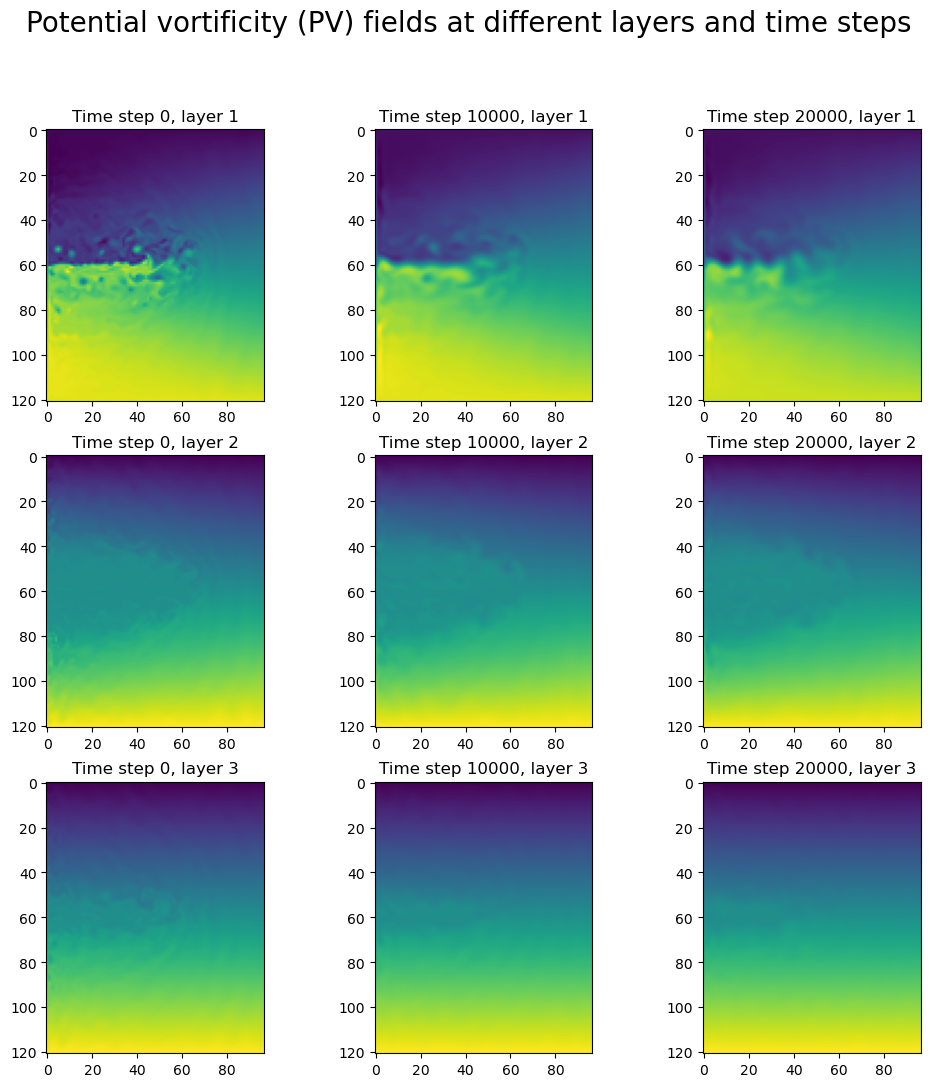

In [ ]:
vmin, vmax = torch.min(time_series_q_over_f0), torch.max(time_series_q_over_f0)

normalized_ts_q_over_f0 = (time_series_q_over_f0.to(torch.float16) - vmin) / (vmax - vmin)

times = [k*10000 for k in range(3)]
fig, ax = plt.subplots(3, 3, figsize=(12,12))

fig.suptitle('Potential vortificity (PV) fields at different layers and time steps', fontsize=20)

ax[0,0].imshow(normalized_ts_q_over_f0[times[0], 0].permute((1,0)))
ax[0,0].set_title(f'Time step {times[0]}, layer 1')

ax[0,1].imshow(normalized_ts_q_over_f0[times[1], 0].permute((1,0)))
ax[0,1].set_title(f'Time step {times[1]}, layer 1')

ax[0,2].imshow(normalized_ts_q_over_f0[times[2], 0].permute((1,0)))
ax[0,2].set_title(f'Time step {times[2]}, layer 1')

ax[1,0].imshow(normalized_ts_q_over_f0[times[0], 1].permute((1,0)))
ax[1,0].set_title(f'Time step {times[0]}, layer 2')

ax[1,1].imshow(normalized_ts_q_over_f0[times[1], 1].permute((1,0)))
ax[1,1].set_title(f'Time step {times[1]}, layer 2')

ax[1,2].imshow(normalized_ts_q_over_f0[times[2], 1].permute((1,0)))
ax[1,2].set_title(f'Time step {times[2]}, layer 2')

ax[2,0].imshow(normalized_ts_q_over_f0[times[0], 2].permute((1,0)))
ax[2,0].set_title(f'Time step {times[0]}, layer 3')

ax[2,1].imshow(normalized_ts_q_over_f0[times[1], 2].permute((1,0)))
ax[2,1].set_title(f'Time step {times[1]}, layer 3')

ax[2,2].imshow(normalized_ts_q_over_f0[times[2], 2].permute((1,0)))
ax[2,2].set_title(f'Time step {times[2]}, layer 3')

We now add some Gaussian noise and a binary mask on the true time series, in order to generate corresponding observations.

# Strong-constraint 4DVar on p and q/f0

In [ ]:
start_index = 25000
n_obs_steps = 2000

fields_tensordict = TensorDict(p=time_series_p.unsqueeze(0).to(device), 
                               q_over_f0=time_series_q_over_f0.unsqueeze(0).to(device), 
                               batch_size=(1, time_series_p.shape[0]))
true_ts = State(fields_tensordict, time_axis=torch.arange(0, dt*(n_steps+1), dt, dtype=torch.float64))
true_ts = true_ts.restrict_time_domain(true_ts.time_axis[start_index], true_ts.time_axis[start_index+n_obs_steps]) # we restrict the assimilation window to the desired range
true_ts.fields = true_ts.fields.to(device) # Put the restricted time series on GPU

noise_amplitude = {'p': 0.02, 'q_over_f0': 0.01} # observation noise s.d.
p_obs = 0.005 # 99.5% of the variables are masked

groundtruth, obs_op, observations = random_sparse_noisy_obs(true_ts, noise_amplitude, p_obs)

Text(0.5, 1.0, 'Time step 1999, observations')

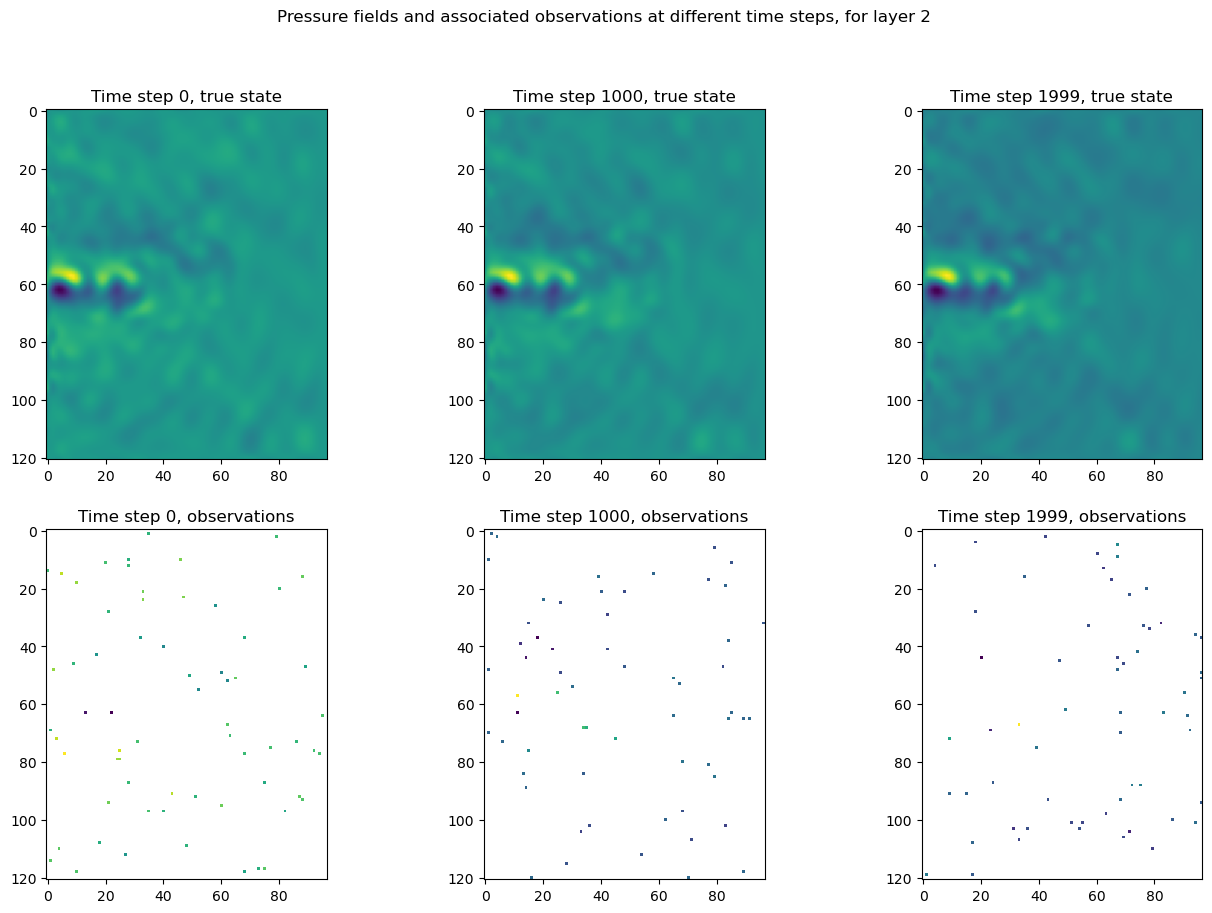

In [ ]:
layer = 1 # choose the layer to show among [0, 1, 2]

times = [0, n_obs_steps // 2, n_obs_steps-1]
fig, ax = plt.subplots(2, 3, figsize=(16,10))

fig.suptitle(f'Pressure fields and associated observations at different time steps, for layer {layer+1}')

ax[0,0].imshow(true_ts.fields['p'][0, times[0], layer].detach().cpu().permute((1,0)))
ax[0,0].set_title(f'Time step {times[0]}, true state')

ax[0,1].imshow(true_ts.fields['p'][0, times[1], layer].detach().cpu().permute((1,0)))
ax[0,1].set_title(f'Time step {times[1]}, true state')

ax[0,2].imshow(true_ts.fields['p'][0, times[2], layer].detach().cpu().permute((1,0)))
ax[0,2].set_title(f'Time step {times[2]}, true state')

ax[1,0].imshow(observations.state.fields['p'][0, times[0], layer].cpu().detach().permute((1,0)), interpolation='none')
ax[1,0].set_title(f'Time step {times[0]}, observations')

ax[1,1].imshow(observations.state.fields['p'][0, times[1], layer].cpu().detach().permute((1,0)), interpolation='none')
ax[1,1].set_title(f'Time step {times[1]}, observations')

ax[1,2].imshow(observations.state.fields['p'][0, times[2], layer].cpu().detach().permute((1,0)), interpolation='none')
ax[1,2].set_title(f'Time step {times[2]}, observations')

In [ ]:
Cl2m = qg_multilayer.Cl2m
Cm2l = qg_multilayer.Cm2l
jac_coef, jacobi_h = qg_multilayer.jac_coef, qg_multilayer.jacobi_h
p_prime = qg_multilayer.p_prime
laplacian_h = qg_multilayer.laplacian_h
zfbc = qg_multilayer.zfbc

def next_step_function(x: State, dt: float, dynamic_inputs: State, static_inputs: State):
    """ Time itegration with Heun (RK2) scheme.
    Input x is a state containing 2 fields: p and q/f0"""
    B, T = x.fields.batch_size[:2]
    assert (B, T) == (1, 1), "Input state x is expected to have no batch or time dimensions"
    p = x.fields["p"].flatten(0, 2) # remove batch and time dimensions
    q_over_f0 = x.fields["q_over_f0"].flatten(0, 2) # remove batch and time dimensions
    #print(p.shape, q_over_f0.shape)
    qg_multilayer.p = p
    qg_multilayer.q_over_f0 = q_over_f0
    qg_multilayer.compute_time_derivatives()
    dq_over_f0_0, dp_0 = qg_multilayer.dq_over_f0, qg_multilayer.dp
    #print(dt, dq_over_f0_0)
    q_over_f0_intermed = qg_multilayer.q_over_f0 + dt * dq_over_f0_0
    p_intermed = qg_multilayer.p + dt * dp_0
    qg_multilayer.p, qg_multilayer.q_over_f0 = p_intermed, q_over_f0_intermed

    qg_multilayer.compute_time_derivatives()
    q_over_f0_next =  q_over_f0_intermed + dt * 0.5 * (qg_multilayer.dq_over_f0 - dq_over_f0_0)
    p_next = p_intermed + dt * 0.5 * (qg_multilayer.dp - dp_0)

    new_fields = TensorDict(p=p_next.reshape(1, 1, *p_next.shape), 
                            q_over_f0=q_over_f0_next.reshape(1, 1, *q_over_f0_next.shape), 
                            batch_size=(B, T))
    return State(new_fields, time_axis=x.time_axis + dt) # return State object, advancing time

In [ ]:
initialization = naive_initialization(observations, default_value=0)[:,:1] # naive initialization on the firt time step of the time series
initialization.fields = initialization.fields.to(device)

# We take care of the pixels that have no observations in the window by attributing them the average value of neighboring locations on the layer
_, _, ind1, ind2, ind3 = torch.where(initialization.fields['p'] == 0)
for k in range(len(ind1)):
    bounds2 = (max(ind2[k]-1, 0), min(ind2[k]+1, initialization.fields['p'].shape[3]))
    bounds3 = (max(ind3[k]-1, 0), min(ind3[k]+1, initialization.fields['p'].shape[4]))
    initialization.fields['p'][0, 0, ind1[k], ind2[k], ind3[k]] = torch.mean(initialization.fields['p'][0, 0, ind1[k], bounds2[0]:bounds2[1], bounds3[0]:bounds3[1]])
_, _, ind1, ind2, ind3 = torch.where(initialization.fields['q_over_f0'] == 0)
for k in range(len(ind1)):
    bounds2 = (max(ind2[k]-1, 0), min(ind2[k]+1, initialization.fields['q_over_f0'].shape[3]))
    bounds3 = (max(ind3[k]-1, 0), min(ind3[k]+1, initialization.fields['q_over_f0'].shape[4]))
    initialization.fields['q_over_f0'][0, 0, ind1[k], ind2[k], ind3[k]] = torch.mean(initialization.fields['q_over_f0'][0, 0, ind1[k], bounds2[0]:bounds2[1], bounds3[0]:bounds3[1]])


Text(0.5, 1.0, 'Error of initialization (PV)')

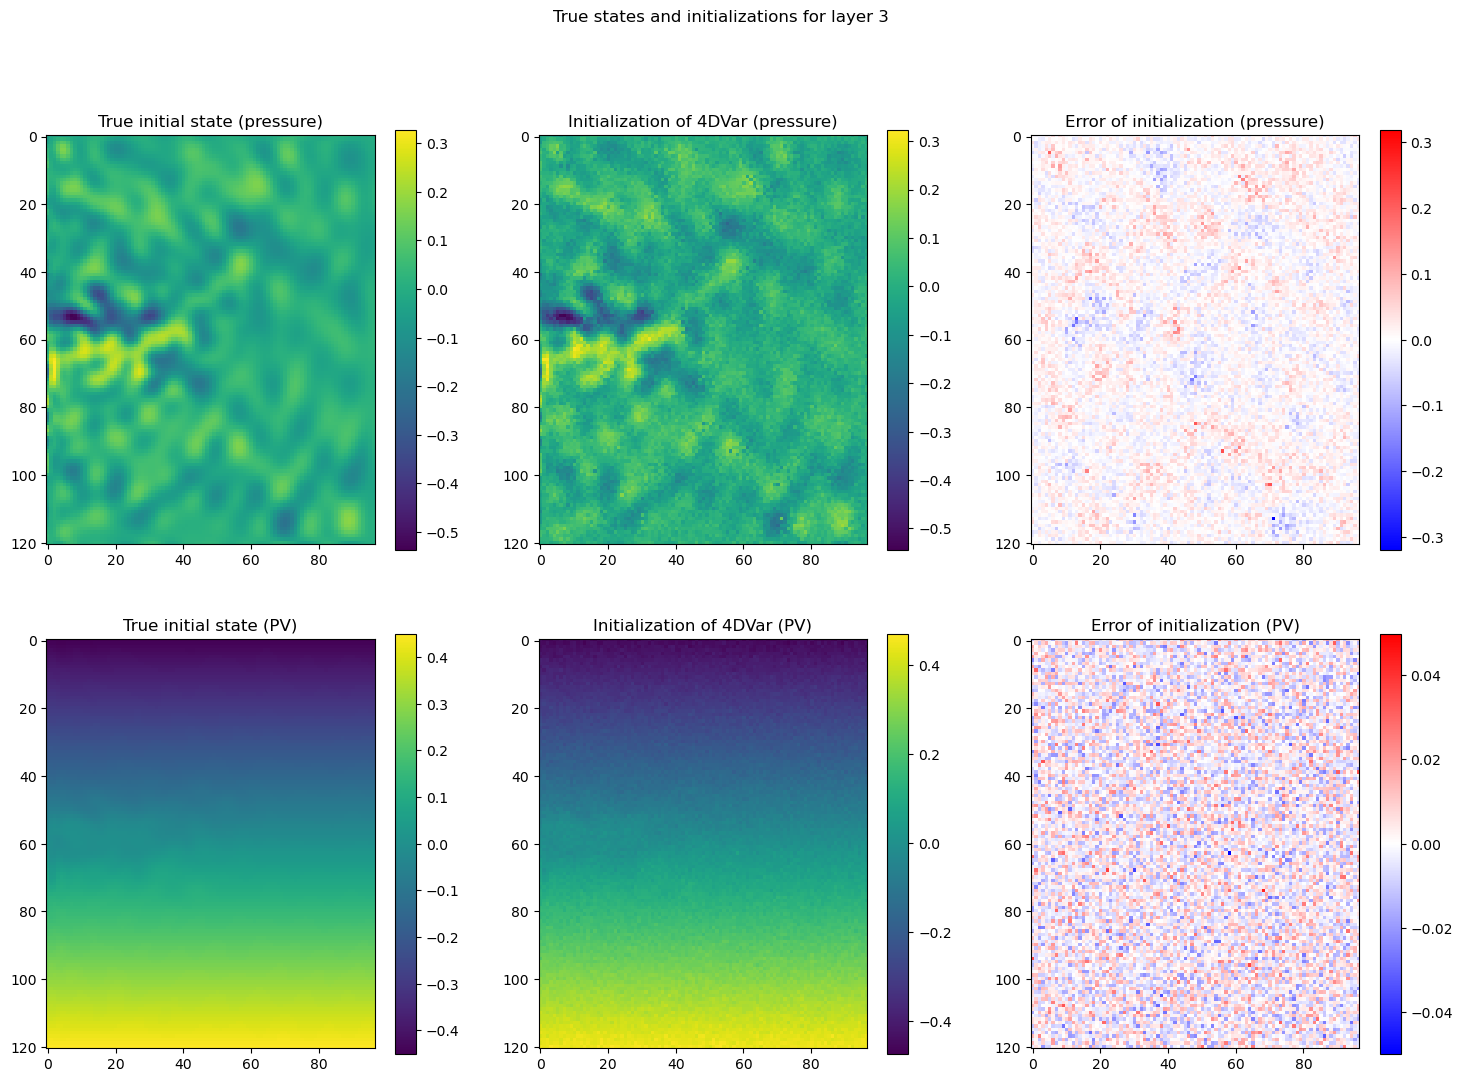

In [ ]:
layer = 2 # choose the layer to show among [0, 1, 2]
title_fontsize = 12

fig, ax = plt.subplots(2, 3, figsize=(18,12))

fig.suptitle(f'True states and initializations for layer {layer+1}')

img_0 = ax[0,0].imshow(true_ts.fields['p'][0, 0, layer].detach().cpu().permute((1,0)))
plt.colorbar(img_0, ax=ax[0,0])
ax[0,0].set_title(f'True initial state (pressure)', fontsize=title_fontsize)

img_1 = ax[0,1].imshow(initialization.fields['p'][0, 0, layer].detach().cpu().permute((1,0)))
plt.colorbar(img_1, ax=ax[0,1])
ax[0,1].set_title(f'Initialization of 4DVar (pressure)', fontsize=title_fontsize)

vmax_abs = torch.max((true_ts[:,0:1] - initialization).fields['p'][0,0, layer].abs())
img_2 = ax[0,2].imshow((true_ts[:,0:1] - initialization).fields['p'][0, 0, layer].detach().cpu().permute((1,0)),
                       vmin=-vmax_abs, vmax=vmax_abs, cmap='bwr')
plt.colorbar(img_2, ax=ax[0,2])
ax[0,2].set_title(f'Error of initialization (pressure)', fontsize=title_fontsize)

img_3 = ax[1,0].imshow(true_ts.fields['q_over_f0'][0, 0, layer].detach().cpu().permute((1,0)))
plt.colorbar(img_3, ax=ax[1,0])
ax[1,0].set_title(f'True initial state (PV)', fontsize=title_fontsize)

img_4 = ax[1,1].imshow(initialization.fields['q_over_f0'][0, 0, layer].detach().cpu().permute((1,0)))
plt.colorbar(img_4, ax=ax[1,1])
ax[1,1].set_title(f'Initialization of 4DVar (PV)', fontsize=title_fontsize)

vmax_abs = torch.max((true_ts[:,0:1] - initialization).fields['q_over_f0'][0,0, layer].abs())
img_5 = ax[1,2].imshow((true_ts[:,0:1] - initialization).fields['q_over_f0'][0, 0, layer].detach().cpu().permute((1,0)),
                       vmin=-vmax_abs, vmax=vmax_abs, cmap='bwr')
plt.colorbar(img_5, ax=ax[1,2])
ax[1,2].set_title(f'Error of initialization (PV)', fontsize=title_fontsize)

In [ ]:
# This should last around 30 minutes

t0 = time()
assimilated_ic = hc4dvar_single_window(next_step_function, 
                                       observations, 
                                       obs_op, 
                                       initialization,
                                       optimizer_class=torch.optim.Adam,
                                       optimizer_pars={'lr': 5e-3},
                                       scheduler_class=torch.optim.lr_scheduler.CyclicLR,
                                       scheduler_pars={'base_lr': 2e-3, 'max_lr': 5e-3, 'step_size_up': 10},
                                       n_steps=50,
                                       verbose=1
                                       )                                     
print(f'Total time for the 4Dvar optimization: {time() - t0} seconds')

iteration 0: loss = 1894396.6322875905
iteration 0: lr = 0.0023000000000000004
iteration 1: loss = 1476106.9088463732
iteration 1: lr = 0.0026000000000000007
iteration 2: loss = 1317344.8135716382
iteration 2: lr = 0.0028999999999999994
iteration 3: loss = 1165832.6880186894
iteration 3: lr = 0.0031999999999999997
iteration 4: loss = 1053650.8039340368
iteration 4: lr = 0.0035
iteration 5: loss = 968354.7503283997
iteration 5: lr = 0.0038000000000000004
iteration 6: loss = 899090.2867039368
iteration 6: lr = 0.004100000000000001
iteration 7: loss = 855181.9588900547
iteration 7: lr = 0.004399999999999999
iteration 8: loss = 828242.4423710358
iteration 8: lr = 0.004699999999999999
iteration 9: loss = 797815.2548549627
iteration 9: lr = 0.005
iteration 10: loss = 777427.6245129191
iteration 10: lr = 0.004699999999999999
iteration 11: loss = 758363.4190235294
iteration 11: lr = 0.004399999999999999
iteration 12: loss = 743178.512402033
iteration 12: lr = 0.004100000000000001
iteration 13:

MSE of initialization: (0.0009150706517983908, 0.00010089372300959716)
MSE of assimilated state: (0.00037015505269346753, 6.271747844232238e-05)


Text(0.5, 1.0, 'Error of assimilation (PV)')

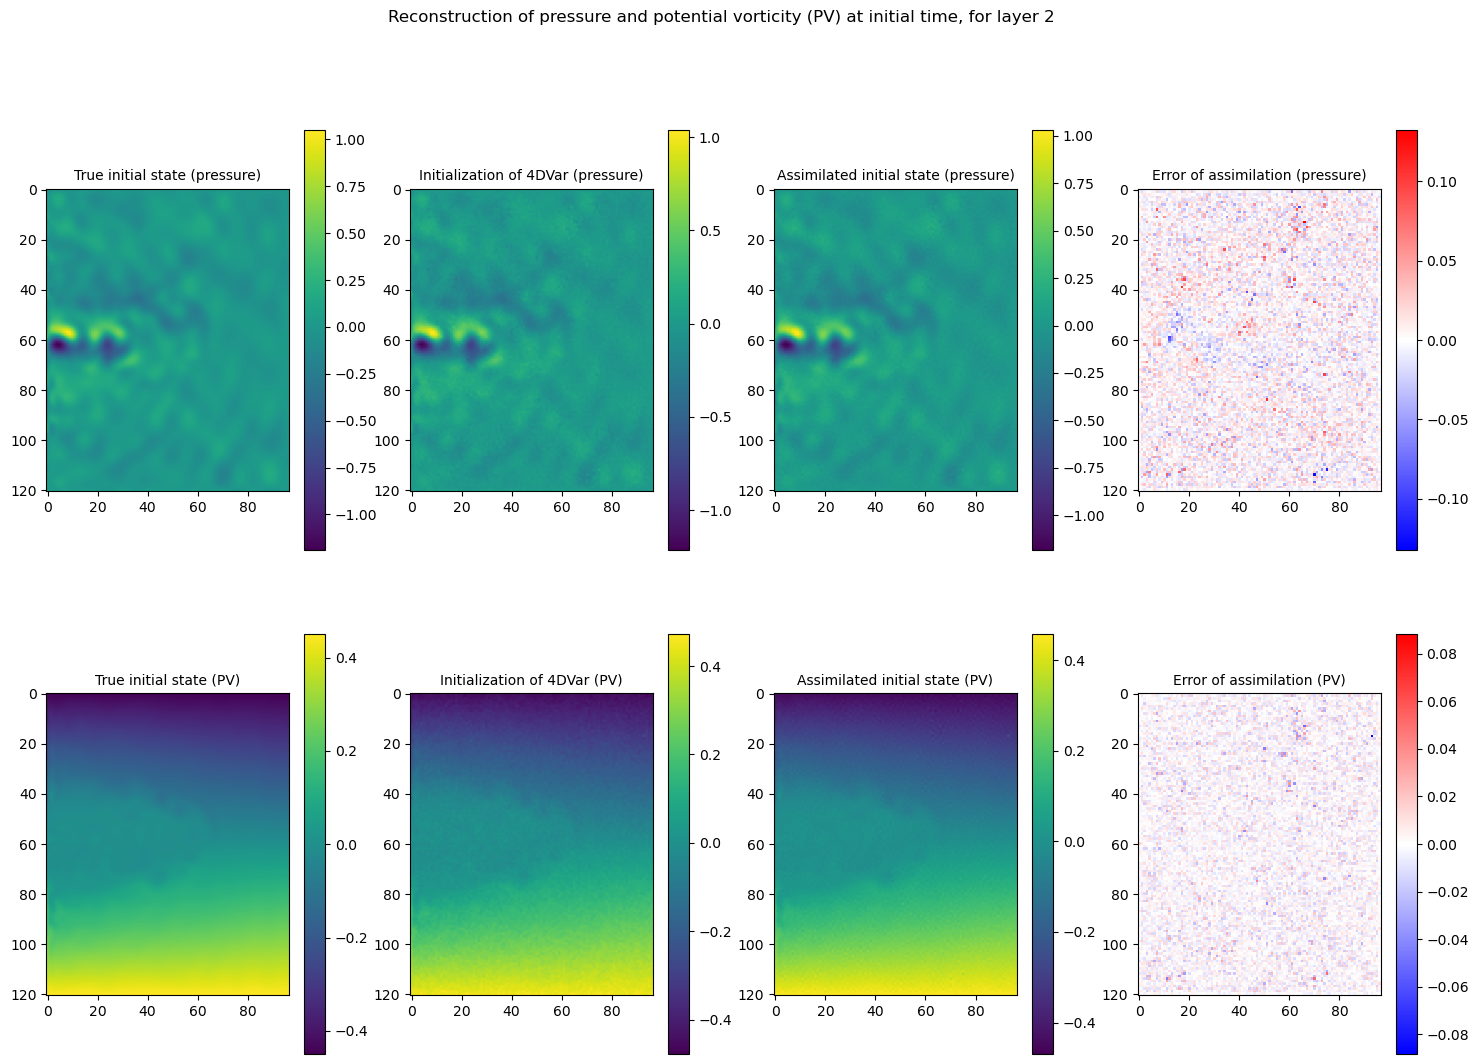

In [ ]:
print(f"MSE of initialization: {torch.mean((initialization - true_ts[:,0:1]).fields['p'] **2).item(), torch.mean((initialization - true_ts[:,0:1]).fields['q_over_f0'] **2).item()}")
print(f"MSE of assimilated state: {torch.mean((assimilated_ic - true_ts[:,0:1]).fields['p'] **2).item(), torch.mean((assimilated_ic - true_ts[:,0:1]).fields['q_over_f0'] **2).item()}")

layer = 1 # choose the layer to show among [0, 1, 2]
title_fontsize = 10

fig, ax = plt.subplots(2, 4, figsize=(18,12))

fig.suptitle(f'Reconstruction of pressure and potential vorticity (PV) at initial time, for layer {layer+1}')

img_0 = ax[0,0].imshow(true_ts.fields['p'][0, 0, layer].detach().cpu().permute((1,0)))
plt.colorbar(img_0, ax=ax[0,0])
ax[0,0].set_title(f'True initial state (pressure)', fontsize=title_fontsize)

img_1 = ax[0,1].imshow(initialization.fields['p'][0, 0, layer].detach().cpu().permute((1,0)))
plt.colorbar(img_1, ax=ax[0,1])
ax[0,1].set_title(f'Initialization of 4DVar (pressure)', fontsize=title_fontsize)

img_2 = ax[0,2].imshow(assimilated_ic.fields['p'][0, 0, layer].detach().cpu().permute((1,0)))
plt.colorbar(img_2, ax=ax[0,2])
ax[0,2].set_title(f'Assimilated initial state (pressure)', fontsize=title_fontsize)

vmax_abs = torch.max((true_ts[:,0:1] - assimilated_ic).fields['p'][0,0, layer].abs())
img_3 = ax[0,3].imshow((true_ts[:,0:1] - assimilated_ic).fields['p'][0, 0, layer].detach().cpu().permute((1,0)),
                       vmin=-vmax_abs, vmax=vmax_abs, cmap='bwr', interpolation='none')
plt.colorbar(img_3, ax=ax[0,3])
ax[0,3].set_title(f'Error of assimilation (pressure)', fontsize=title_fontsize)

img_4 = ax[1,0].imshow(true_ts.fields['q_over_f0'][0, 0, layer].detach().cpu().permute((1,0)))
plt.colorbar(img_4, ax=ax[1,0])
ax[1,0].set_title(f'True initial state (PV)', fontsize=title_fontsize)

img_5 = ax[1,1].imshow(initialization.fields['q_over_f0'][0, 0, layer].detach().cpu().permute((1,0)))
plt.colorbar(img_5, ax=ax[1,1])
ax[1,1].set_title(f'Initialization of 4DVar (PV)', fontsize=title_fontsize)

img_6 = ax[1,2].imshow(assimilated_ic.fields['q_over_f0'][0, 0, layer].detach().cpu().permute((1,0)))
plt.colorbar(img_6, ax=ax[1,2])
ax[1,2].set_title(f'Assimilated initial state (PV)', fontsize=title_fontsize)

vmax_abs = torch.max((true_ts[:,0:1] - assimilated_ic).fields['q_over_f0'][0,0, layer].abs())
img_7 = ax[1,3].imshow((true_ts[:,0:1] - assimilated_ic).fields['q_over_f0'][0, 0, layer].detach().cpu().permute((1,0)),
                       vmin=-vmax_abs, vmax=vmax_abs, cmap='bwr', interpolation='none')
plt.colorbar(img_7, ax=ax[1,3])
ax[1,3].set_title(f'Error of assimilation (PV)', fontsize=title_fontsize)

We now run a long-term prediction from our assimilated initial state and compare it to an accordingly extended ground truth series.

In [ ]:
from da_tools.util.state_space import rollout

n_forecast_steps = 6000 # This might cause a GPU memory issue. If this happens, try a lower number or run the prediction on CPU

fields_tensordict = TensorDict(p=time_series_p.unsqueeze(0), 
                               q_over_f0=time_series_q_over_f0.unsqueeze(0), 
                               batch_size=(1, time_series_p.shape[0]))
true_ts_extended = State(fields_tensordict, time_axis=torch.arange(0, dt*(n_steps+1), dt, dtype=torch.float64))
true_ts_extended = true_ts_extended.restrict_time_domain(true_ts_extended.time_axis[start_index], true_ts_extended.time_axis[start_index+n_forecast_steps]) # we restrict the assimilation window to the desired range

predictions = rollout(next_step_function, true_ts_extended.time_axis, assimilated_ic)
predictions.fields = predictions.fields.to('cpu')

Text(0.5, 1.0, 'Time step 5000, forecast from assimilated state')

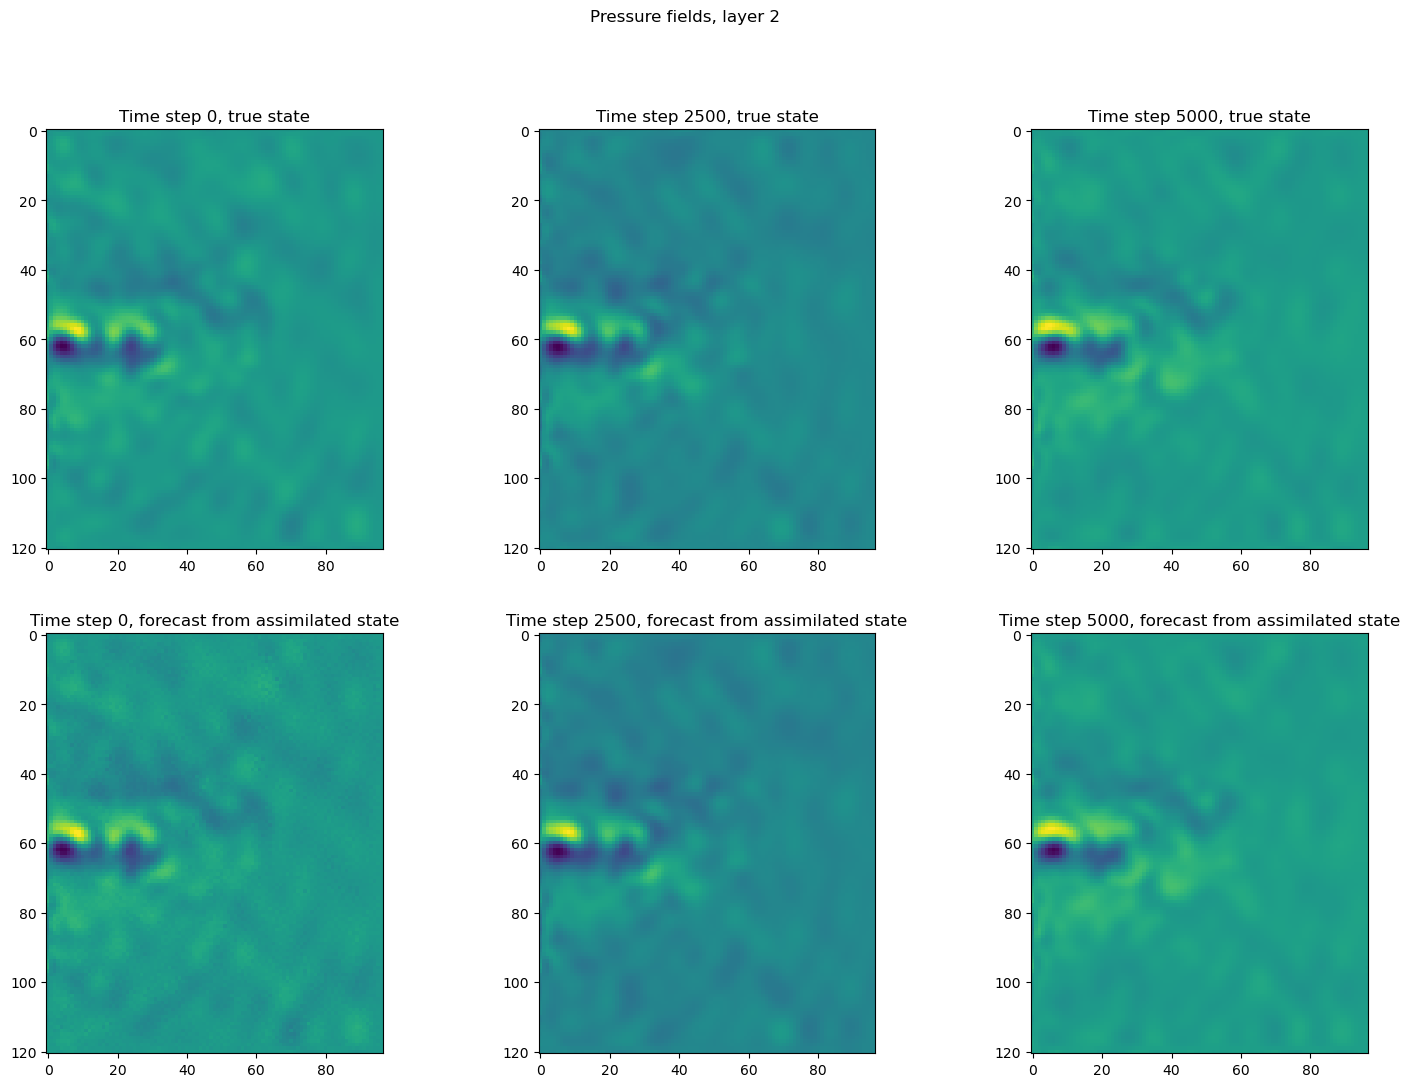

In [ ]:
field = 'p' # choose the field among ['p', 'q_over_f0']
layer = 1 # choose the layer to show among [0, 1, 2]


times = [0, 500, 999]
times = [0, 2500, 5000]
fig, ax = plt.subplots(2, 3, figsize=(18,12))

fig.suptitle(f'Pressure fields, layer {layer+1}')

ax[0,0].imshow(true_ts_extended.fields['p'][0, times[0], layer].detach().cpu().permute((1,0)))
ax[0,0].set_title(f'Time step {times[0]}, true state')

ax[0,1].imshow(true_ts_extended.fields['p'][0, times[1], layer].detach().cpu().permute((1,0)))
ax[0,1].set_title(f'Time step {times[1]}, true state')

ax[0,2].imshow(true_ts_extended.fields['p'][0, times[2], layer].detach().cpu().permute((1,0)))
ax[0,2].set_title(f'Time step {times[2]}, true state')

ax[1,0].imshow(predictions.fields['p'][0, times[0], layer].detach().cpu().permute((1,0)))
ax[1,0].set_title(f'Time step {times[0]}, forecast from assimilated state')

ax[1,1].imshow(predictions.fields['p'][0, times[1], layer].detach().cpu().permute((1,0)))
ax[1,1].set_title(f'Time step {times[1]}, forecast from assimilated state')

ax[1,2].imshow(predictions.fields['p'][0, times[2], layer].detach().cpu().permute((1,0)))
ax[1,2].set_title(f'Time step {times[2]}, forecast from assimilated state')

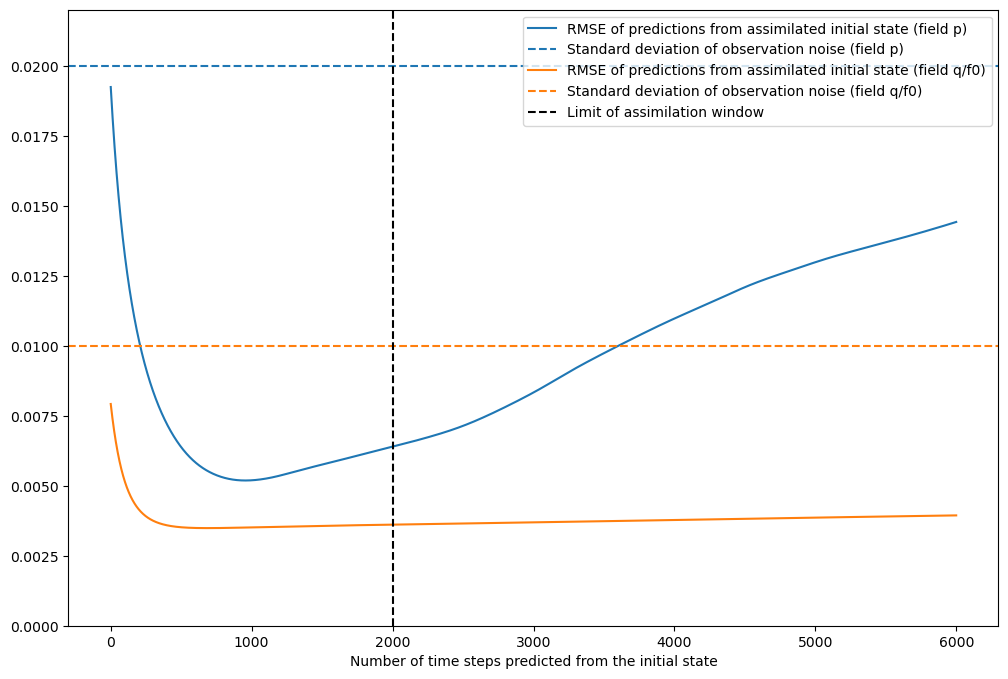

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_ylim(0, 1.1*noise_amplitude['p'])

RMSE_in_time_p = torch.sqrt(torch.mean((predictions - true_ts_extended).fields['p'] **2, axis=(0, 2, 3, 4)))
plt.plot(RMSE_in_time_p.detach().cpu(), label='RMSE of predictions from assimilated initial state (field p)', c='tab:blue')
plt.axhline(noise_amplitude['p'], c='tab:blue', linestyle='--', label='Standard deviation of observation noise (field p)')

RMSE_in_time_q = torch.sqrt(torch.mean((predictions - true_ts_extended).fields['q_over_f0'] **2, axis=(0, 2, 3, 4)))
plt.plot(RMSE_in_time_q.detach().cpu(), c='tab:orange', 
         label='RMSE of predictions from assimilated initial state (field q/f0)')
plt.axhline(noise_amplitude['q_over_f0'], c='tab:orange', linestyle='--', 
            label='Standard deviation of observation noise (field q/f0)')

plt.axvline(n_obs_steps, c='black', linestyle='--', label='Limit of assimilation window')

plt.xlabel('Number of time steps predicted from the initial state')

plt.legend()

Interestingly, the RMSE is not lowest at the beginning of the assimilation window but in the middle/end of it. It then gradually increases with time, but stays below the level of observation noise for quite a long time.

# Strong-constraint 4DVar on p

This time, our state object contains only the pressure fields.

In [ ]:
start_index = 25000
n_obs_steps = 2000

fields_tensordict = TensorDict(p=time_series_p.unsqueeze(0), 
                               batch_size=(1, time_series_p.shape[0]))
true_ts = State(fields_tensordict, time_axis=torch.arange(0, dt*(n_steps+1), dt, dtype=torch.float64))
true_ts = true_ts.restrict_time_domain(true_ts.time_axis[start_index], true_ts.time_axis[start_index+n_obs_steps]) # we restrict the assimilation window to the desired range
true_ts.fields = true_ts.fields.to(device) # Put the restricted time series on GPU

noise_amplitude = 0.02  # observation noise s.d.
p_obs = 0.005 # 99.5% of the variables are masked

groundtruth, obs_op, observations = random_sparse_noisy_obs(true_ts, noise_amplitude, p_obs)

Text(0.5, 1.0, 'Time step 1999, observations')

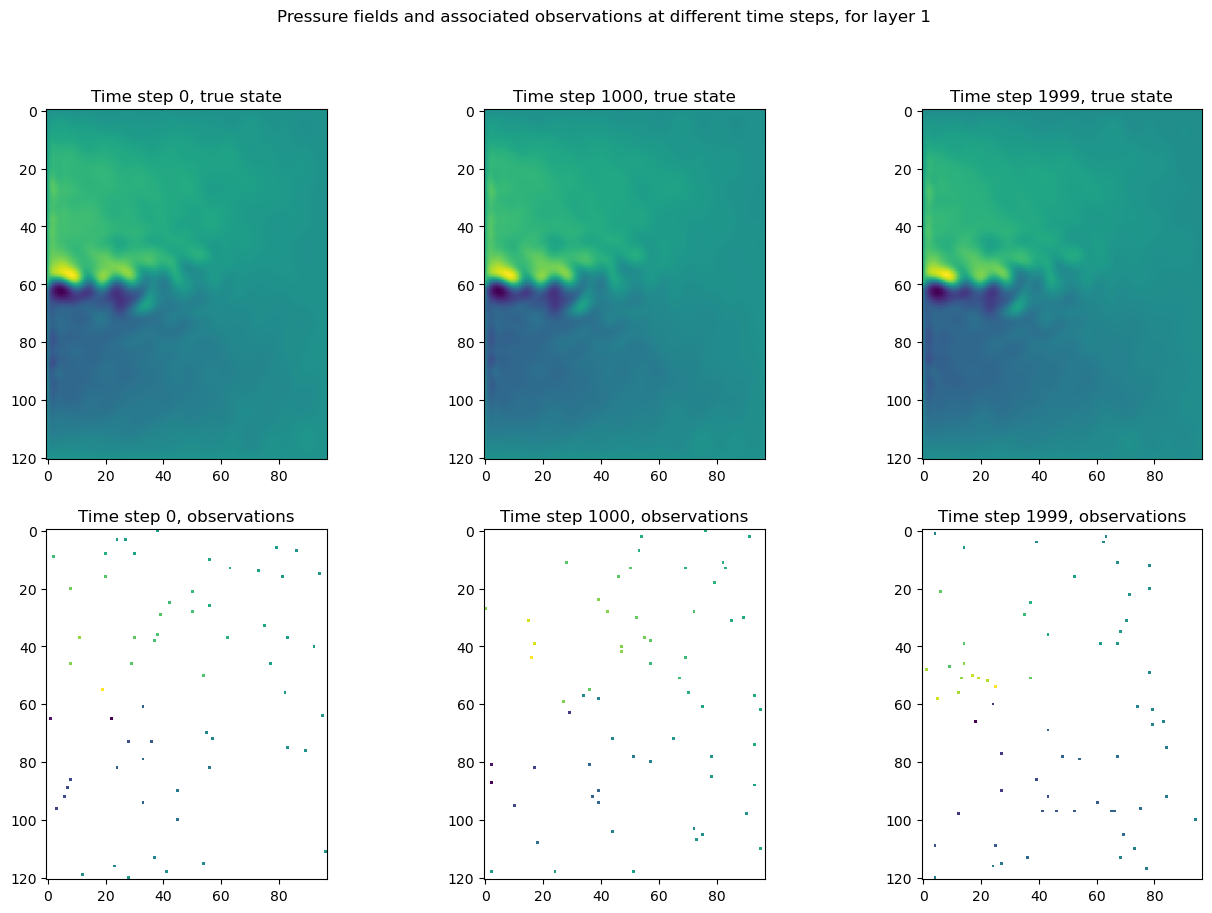

In [ ]:
layer = 0 # choose the layer to show among [0, 1, 2]

times = [0, n_obs_steps // 2, n_obs_steps - 1]
fig, ax = plt.subplots(2, 3, figsize=(16,10))

fig.suptitle(f'Pressure fields and associated observations at different time steps, for layer {layer+1}')

ax[0,0].imshow(true_ts.fields['p'][0, times[0], layer].detach().cpu().permute((1,0)))
ax[0,0].set_title(f'Time step {times[0]}, true state')

ax[0,1].imshow(true_ts.fields['p'][0, times[1], layer].detach().cpu().permute((1,0)))
ax[0,1].set_title(f'Time step {times[1]}, true state')

ax[0,2].imshow(true_ts.fields['p'][0, times[2], layer].detach().cpu().permute((1,0)))
ax[0,2].set_title(f'Time step {times[2]}, true state')

ax[1,0].imshow(observations.state.fields['p'][0, times[0], layer].cpu().detach().permute((1,0)), interpolation='none')
ax[1,0].set_title(f'Time step {times[0]}, observations')

ax[1,1].imshow(observations.state.fields['p'][0, times[1], layer].cpu().detach().permute((1,0)), interpolation='none')
ax[1,1].set_title(f'Time step {times[1]}, observations')

ax[1,2].imshow(observations.state.fields['p'][0, times[2], layer].cpu().detach().permute((1,0)), interpolation='none')
ax[1,2].set_title(f'Time step {times[2]}, observations')

In [ ]:
Cl2m = qg_multilayer.Cl2m
Cm2l = qg_multilayer.Cm2l
jac_coef, jacobi_h = qg_multilayer.jac_coef, qg_multilayer.jacobi_h
p_prime = qg_multilayer.p_prime
laplacian_h = qg_multilayer.laplacian_h
zfbc = qg_multilayer.zfbc

def next_step_function(x: State, dt: float, dynamic_inputs: State, static_inputs: State):
    """ Time itegration with Heun (RK2) scheme.
    Input x is a state containing 2 fields: p and q/f0"""
    B, T = x.fields.batch_size[:2]
    assert (B, T) == (1, 1), "Input state x is expected to have no batch or time dimensions"
    p = x.fields["p"].flatten(0, 2) # remove batch and time dimensions
    qg_multilayer.p = p
    qg_multilayer.compute_q_over_f0_from_p() # Use the state p to compute q/f0 before integration
    qg_multilayer.compute_time_derivatives()
    dq_over_f0_0, dp_0 = qg_multilayer.dq_over_f0, qg_multilayer.dp
    q_over_f0_intermed = qg_multilayer.q_over_f0 + dt * dq_over_f0_0
    p_intermed = qg_multilayer.p + dt * dp_0
    qg_multilayer.p, qg_multilayer.q_over_f0 = p_intermed, q_over_f0_intermed

    qg_multilayer.compute_time_derivatives(update_PV=False)
    p_next = p_intermed + dt * 0.5 * (qg_multilayer.dp - dp_0)
    # No need to compute q_over_f0_next here

    new_fields = TensorDict(p=p_next.reshape(1, 1, *p_next.shape),
                            batch_size=(B, T))
    return State(new_fields, time_axis=x.time_axis + dt) # return State object, advancing time

In [ ]:
initialization = naive_initialization(observations, default_value=0)[:,:1] # naive initialization on the firt time step of the time series
initialization.fields = initialization.fields.to(device)

# We take care of the variables that have no observations in the window by attributing them the average value of neighboring variables
_, _, ind1, ind2, ind3 = torch.where(initialization.fields['p'] == 0)
for k in range(len(ind1)):
    bounds2 = (max(ind2[k]-1, 0), min(ind2[k]+1, initialization.fields['p'].shape[3]))
    bounds3 = (max(ind3[k]-1, 0), min(ind3[k]+1, initialization.fields['p'].shape[4]))
    initialization.fields['p'][0, 0, ind1[k], ind2[k], ind3[k]] = torch.mean(initialization.fields['p'][0, 0, ind1[k], bounds2[0]:bounds2[1], bounds3[0]:bounds3[1]])

Text(0.5, 1.0, 'Error of initialization')

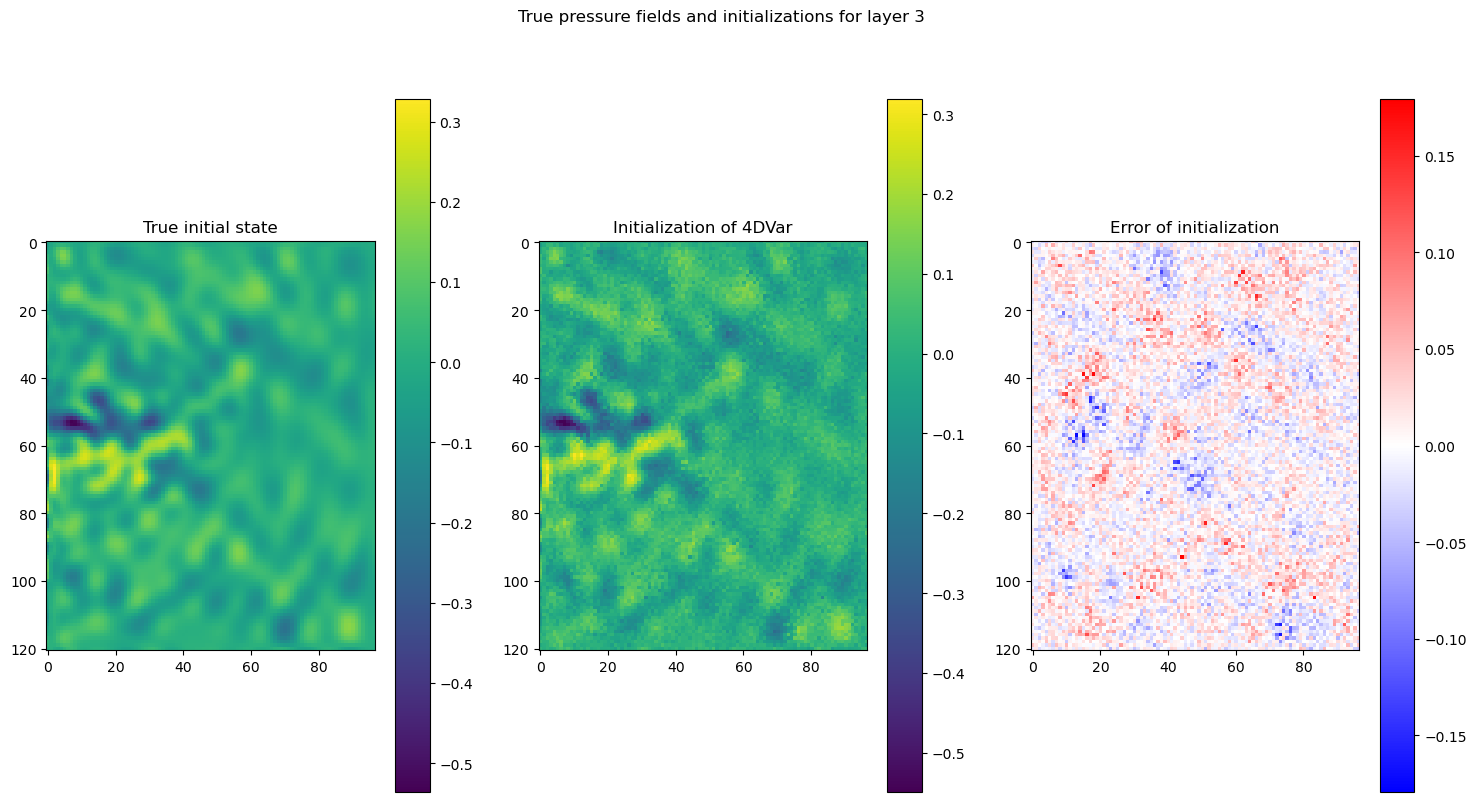

In [ ]:
layer = 2 # choose the layer to show among [0, 1, 2]
title_fontsize = 12

fig, ax = plt.subplots(1, 3, figsize=(18,9))

fig.suptitle(f'True pressure fields and initializations for layer {layer+1}')

img_0 = ax[0].imshow(true_ts.fields['p'][0, 0, layer].detach().cpu().permute((1,0)))
plt.colorbar(img_0, ax=ax[0])
ax[0].set_title(f'True initial state', fontsize=title_fontsize)

img_1 = ax[1].imshow(initialization.fields['p'][0, 0, layer].detach().cpu().permute((1,0)))
plt.colorbar(img_1, ax=ax[1])
ax[1].set_title(f'Initialization of 4DVar', fontsize=title_fontsize)

vmax_abs = torch.max((true_ts[:,0:1] - initialization).fields['p'][0,0, layer].abs())
img_2 = ax[2].imshow((true_ts[:,0:1] - initialization).fields['p'][0, 0, layer].detach().cpu().permute((1,0)),
                       vmin=-vmax_abs, vmax=vmax_abs, cmap='bwr')
plt.colorbar(img_2, ax=ax[2])
ax[2].set_title(f'Error of initialization', fontsize=title_fontsize)

In [ ]:
t0 = time()
assimilated_ic = hc4dvar_single_window(next_step_function, 
                                       observations, 
                                       obs_op, 
                                       initialization,
                                       optimizer_class=torch.optim.Adam,
                                       optimizer_pars={'lr': 5e-3},
                                       scheduler_class=torch.optim.lr_scheduler.CyclicLR,
                                       scheduler_pars={'base_lr': 2e-3, 'max_lr': 5e-3, 'step_size_up': 10},
                                       n_steps=50,
                                       verbose=1
                                       )                                     
print(f'Total time for the 4Dvar optimization: {time() - t0} seconds')

iteration 0: loss = 629714.2290384339
iteration 0: lr = 0.0023000000000000004
iteration 1: loss = 568813.5669411402
iteration 1: lr = 0.0026000000000000007
iteration 2: loss = 523275.81093617517
iteration 2: lr = 0.0028999999999999994
iteration 3: loss = 485790.101721255
iteration 3: lr = 0.0031999999999999997
iteration 4: loss = 454744.0249229999
iteration 4: lr = 0.0035
iteration 5: loss = 430891.3582291154
iteration 5: lr = 0.0038000000000000004
iteration 6: loss = 413007.67400585895
iteration 6: lr = 0.004100000000000001
iteration 7: loss = 398307.6317878483
iteration 7: lr = 0.004399999999999999
iteration 8: loss = 385688.24016216997
iteration 8: lr = 0.004699999999999999
iteration 9: loss = 375628.46954888833
iteration 9: lr = 0.005
iteration 10: loss = 367120.8552280208
iteration 10: lr = 0.004699999999999999
iteration 11: loss = 359602.88511362846
iteration 11: lr = 0.004399999999999999
iteration 12: loss = 354218.78476543
iteration 12: lr = 0.004100000000000001
iteration 13: l

MSE of initialization: 0.0009086444279307246
MSE of assimilated state: 0.0006137106287095833


Text(0.5, 1.0, 'Difference between assimilated and true state')

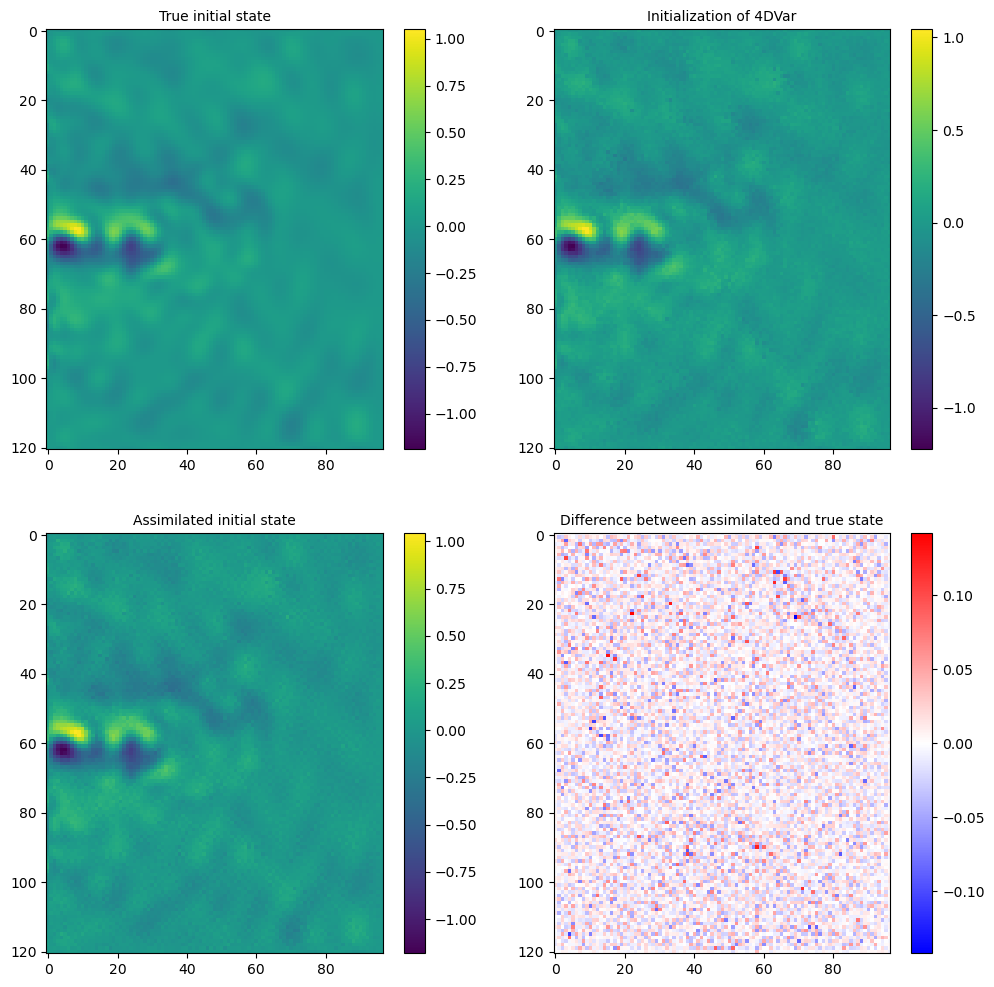

In [ ]:
print(f"MSE of initialization: {torch.mean((initialization - true_ts[:,0:1]).fields['p'] **2).item()}")
print(f"MSE of assimilated state: {torch.mean((assimilated_ic - true_ts[:,0:1]).fields['p'] **2).item()}")

var = 1 # choose the variable to show among [0, 1, 2]
title_fontsize = 10

fig, ax = plt.subplots(2, 2, figsize=(12,12))

img_0 = ax[0,0].imshow(true_ts.fields['p'][0, 0, var].detach().cpu().permute((1,0)))
plt.colorbar(img_0, ax=ax[0,0])
ax[0,0].set_title(f'True initial state', fontsize=title_fontsize)

img_1 = ax[0,1].imshow(initialization.fields['p'][0, 0, var].detach().cpu().permute((1,0)))
plt.colorbar(img_1, ax=ax[0,1])
ax[0,1].set_title(f'Initialization of 4DVar', fontsize=title_fontsize)

img_2 = ax[1,0].imshow(assimilated_ic.fields['p'][0, 0, var].detach().cpu().permute((1,0)))
plt.colorbar(img_2, ax=ax[1,0])
ax[1,0].set_title(f'Assimilated initial state', fontsize=title_fontsize)

vmax_abs = torch.max((true_ts[:,0:1] - assimilated_ic).fields['p'][0,0,var].abs())
img_3 = ax[1,1].imshow((true_ts[:,0:1] - assimilated_ic).fields['p'][0, 0, var].detach().cpu().permute((1,0)),
                       vmin=-vmax_abs, vmax=vmax_abs, cmap='bwr')
plt.colorbar(img_3, ax=ax[1,1])
ax[1,1].set_title(f'Difference between assimilated and true state', fontsize=title_fontsize)

In [ ]:
from da_tools.util.state_space import rollout

n_forecast_steps = 6000 # This might cause a GPU memory issue. If this happens, try a lower number or run the prediction on CPU

fields_tensordict = TensorDict(p=time_series_p.unsqueeze(0),  
                               batch_size=(1, time_series_p.shape[0]))
true_ts_extended = State(fields_tensordict, time_axis=torch.arange(0, dt*(n_steps+1), dt, dtype=torch.float64))
true_ts_extended = true_ts_extended.restrict_time_domain(true_ts_extended.time_axis[start_index], true_ts_extended.time_axis[start_index+n_forecast_steps]) # we restrict the assimilation window to the desired range

predictions = rollout(next_step_function, true_ts_extended.time_axis, assimilated_ic)
predictions.fields = predictions.fields.to('cpu')

Text(0.5, 1.0, 'Time step 5000, forecast from assimilated state')

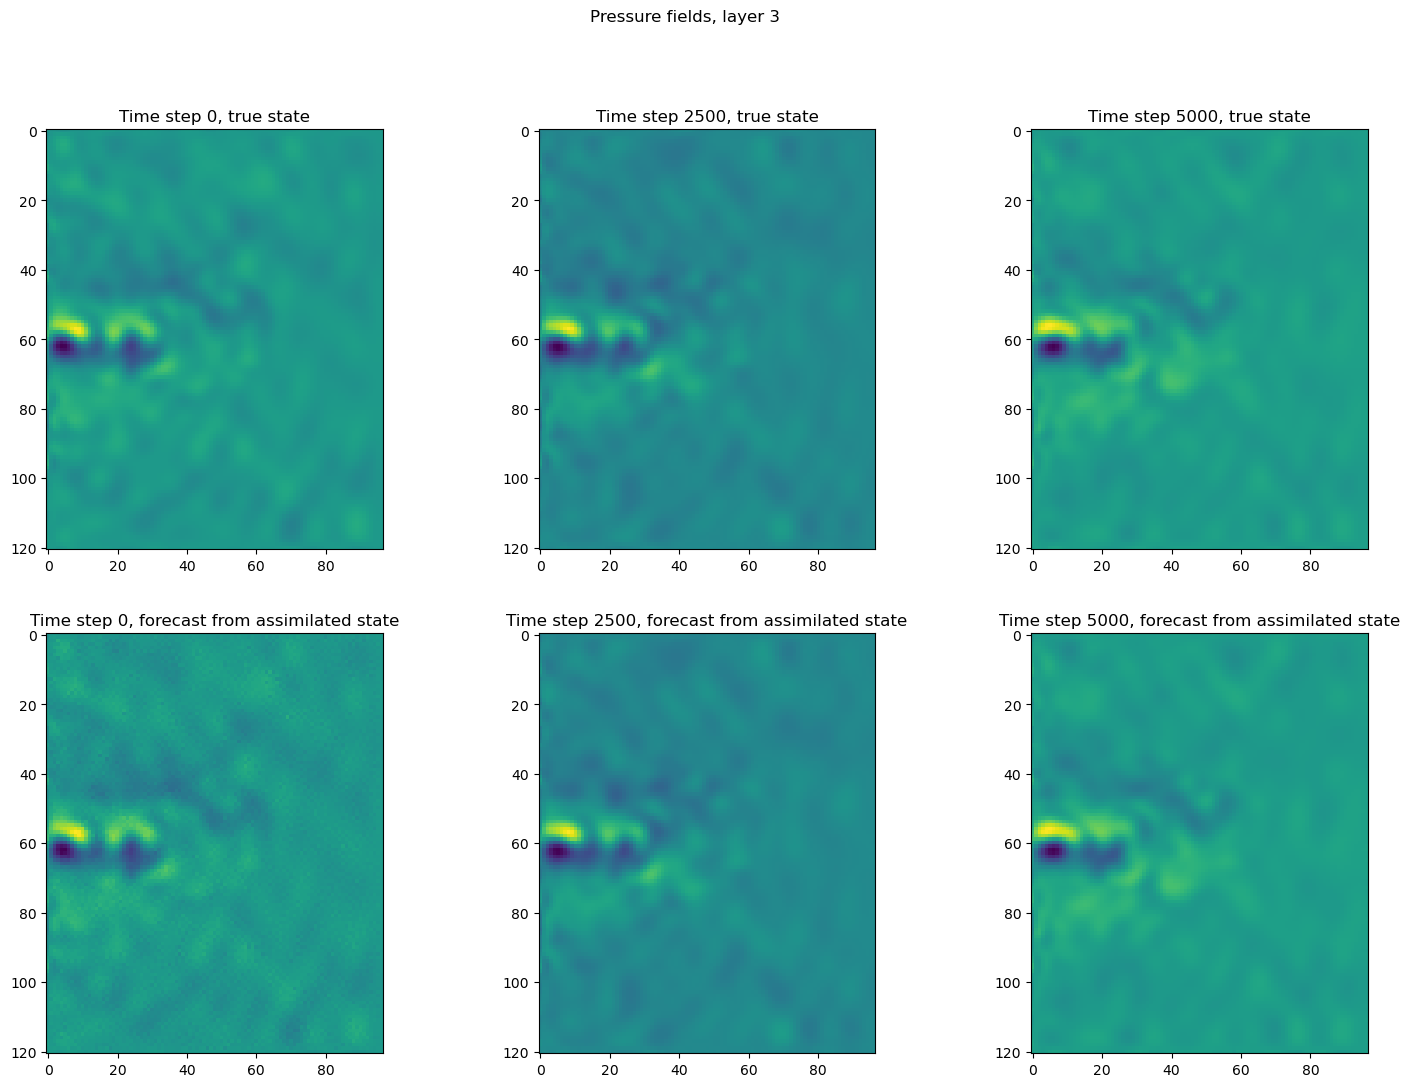

In [ ]:
field = 'p' # choose the field among ['p', 'q_over_f0']
var = 1 # choose the variable to show among [0, 1, 2]


times = [0, 500, 999]
times = [0, 2500, 5000]
fig, ax = plt.subplots(2, 3, figsize=(18,12))

fig.suptitle(f'Pressure fields, layer {layer+1}')

ax[0,0].imshow(true_ts_extended.fields['p'][0, times[0], var].detach().cpu().permute((1,0)))
ax[0,0].set_title(f'Time step {times[0]}, true state')

ax[0,1].imshow(true_ts_extended.fields['p'][0, times[1], var].detach().cpu().permute((1,0)))
ax[0,1].set_title(f'Time step {times[1]}, true state')

ax[0,2].imshow(true_ts_extended.fields['p'][0, times[2], var].detach().cpu().permute((1,0)))
ax[0,2].set_title(f'Time step {times[2]}, true state')

ax[1,0].imshow(predictions.fields['p'][0, times[0], var].detach().cpu().permute((1,0)))
ax[1,0].set_title(f'Time step {times[0]}, forecast from assimilated state')

ax[1,1].imshow(predictions.fields['p'][0, times[1], var].detach().cpu().permute((1,0)))
ax[1,1].set_title(f'Time step {times[1]}, forecast from assimilated state')

ax[1,2].imshow(predictions.fields['p'][0, times[2], var].detach().cpu().permute((1,0)))
ax[1,2].set_title(f'Time step {times[2]}, forecast from assimilated state')

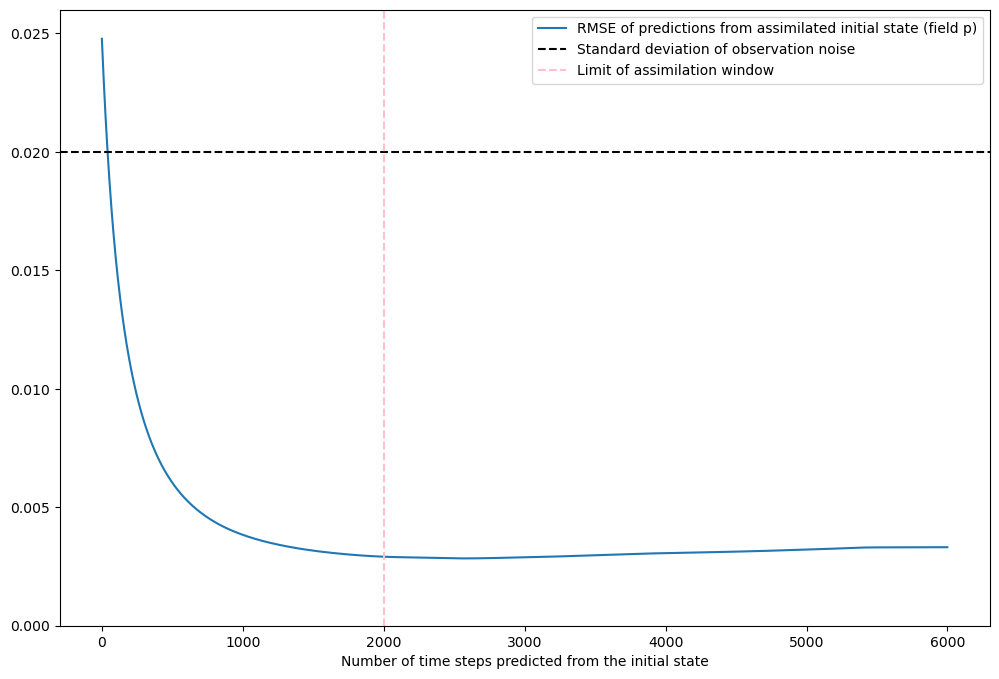

In [ ]:
RMSE_in_time = torch.sqrt(torch.mean((predictions - true_ts_extended).fields['p'] **2, axis=(0, 2, 3, 4)))

fig, ax = plt.subplots(figsize=(12,8))
ax.set_ylim(0, 1.3*noise_amplitude)

plt.plot(RMSE_in_time.detach().cpu(), label='RMSE of predictions from assimilated initial state (field p)')

plt.axhline(noise_amplitude, c='black', linestyle='--', label='Standard deviation of observation noise')
plt.axvline(n_obs_steps, c='pink', linestyle='--', label='Limit of assimilation window')
            
plt.xlabel('Number of time steps predicted from the initial state')


plt.legend()

Compared to the joint assimilation on p and q/f0, the assimilation on p leads to a worse reconstruction at the beginning of the time series but to a much more accurate prediction for long-term forecasts. This might be attributed to the fact that in this case we avoid q/f0 from drifting away for the values that should be associated to f.

These results seem to suggest that sliding-window 4DVar would perform well in these conditions.